## The Basic Idea of Machine-learning

Imagine a monkey drawing on a canvas (say, of `128 * 128` pixels). What's the probability that it draw a human-face? Almost none, isn't it. This implies that

* the manifold of human-face involved in $\mathbb{R}^{128 \times 128}$ has relatively much smaller dimensions.

* Even, the manifold is spares.

To see this, imagine you modify the background of a painting with a human-face in the foreground, the points in $\mathbb{R}^{128 \times 128}$ before and after the modification are generally far from each other.

Thus, the task of machine-learning is to find out the low-dimensional spares manifold, mapping the manifold to a lower dimensional compact space, and mapping the element there back to generate real-world object, like painting.

We call the real-world object "observable", and the low-dimensional spares manifold "latent" space.

This serves both to data-compression and data-abstraction. In fact, these are two aspects of one thing: the probability distribution of data (which we will talk in the next topic).

## Auto-encoder

### Conceptions

This basic idea naturally forces to "auto-encoder", which has two parts:

1. Encoder: mapping the observable to latent.
2. Decoder: mapping the latent to observable.

Let $X$ the space of observable, and $Z$ the latent. Let $f: X \mapsto Z$ denotes the encoder, and $g: Z \mapsto X$ the decoder. Then, for $\forall x \in X$, we would expect

\begin{equation}
  g \circ f(x) \approx x.
\end{equation}

To numerically characterize this approximation, let $d_{\text{obs}}$ some pre-defined distance in the space of observable, we can define loss

\begin{equation}
  \mathcal{L}_{\text{recon}} = \frac{1}{|D|} \sum_{x \in D} d_{\text{obs}} \left(x, g \circ f (x) \right).
\end{equation}

We call this "reconstruction" loss, since $g \circ f (x)$ is a reconstruction of $x$.

For ensuring the compactness of the latent, an additional regularizer is added to the reconstruction loss, by some pre-defined distance in the latant space $d_{\text{lat}}$. Thus, the total loss is

\begin{equation}
  \mathcal{L} = \frac{1}{|D|} \sum_{x \in D} d_{\text{obs}} \left(x, g \circ f (x) \right)
              + d_{\text{lat}} \left( f(x), 0 \right).
\end{equation}

The task is thus to find the functions $f$ and $g$ that minimize the total loss. This utilizes the universality property of neural network.

### Reference:
  1. [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder).

## Implementation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
data_path = '../../dat/MNIST/'
mnist = input_data.read_data_sets(
    data_path, one_hot=True,
    source_url='http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../dat/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../dat/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../dat/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../dat/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def get_encoder(latent_dim, hidden_layers):
    
  def encoder(observable, name='encoder', reuse=None):
    with tf.variable_scope(name, reuse=reuse):
      hidden = observable
      for hidden_layer in hidden_layers:
        hidden = tf.layers.dense(hidden, hidden_layer,
                                 activation=tf.nn.relu)
      latent = tf.layers.dense(hidden, latent_dim, activation=None)
      return latent
    
  return encoder

In [4]:
def get_decoder(observable_dim, hidden_layers):
    
  def decoder(latent, name='decoder', reuse=None):
    with tf.variable_scope(name, reuse=reuse):
      hidden = latent
      for hidden_layer in hidden_layers:
        hidden = tf.layers.dense(hidden, hidden_layer,
                                 activation=tf.nn.relu)
      reconstructed = tf.layers.dense(hidden, observable_dim,
                                      activation=tf.nn.sigmoid)
      return reconstructed
    
  return decoder

In [5]:
def get_loss(observable, encoder, decoder, regularizer=None, reuse=None):
  if regularizer is None:
    regularizer = lambda latent: 0.0
    
  with tf.name_scope('loss'):
    # shape: [batch_size, latent_dim]
    latent = encoder(observable, reuse=reuse)
    # shape: [batch_size, observable_dim]
    reconstructed = decoder(latent, reuse=reuse)
    # shape: [batch_size]
    squared_errors = tf.reduce_sum(
        (reconstructed - observable) ** 2,
        axis=1)
    mean_square_error = tf.reduce_mean(squared_errors)
    return mean_square_error + regularizer(latent)

In [6]:
latent_dim = 64
encoder = get_encoder(latent_dim=latent_dim,
                      hidden_layers=[512, 256, 128])
decoder = get_decoder(observable_dim=28*28,
                      hidden_layers=[128, 256, 512])
observable = tf.placeholder(shape=[None, 28*28],
                            dtype='float32',
                            name='observable')
latent_samples = tf.placeholder(shape=[None, latent_dim],
                                dtype='float32',
                                name='latent_samples')
generated = decoder(latent_samples, reuse=tf.AUTO_REUSE)

In [7]:
def regularizer(latent, name='regularizer'):
  with tf.name_scope(name):
    distances = tf.reduce_sum(latent ** 2, axis=1)
    return tf.reduce_mean(distances)

In [8]:
loss = get_loss(observable, encoder, decoder,
                regularizer=regularizer,
                reuse=tf.AUTO_REUSE)

In [9]:
optimizer = tf.train.AdamOptimizer(epsilon=1e-3)
train_op = optimizer.minimize(loss)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

100%|██████████| 100000/100000 [03:53<00:00, 428.27it/s]


Final loss: 2.66785


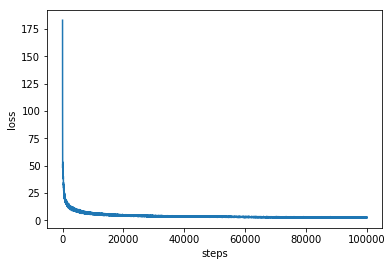

In [11]:
loss_vals = []
for i in tqdm(range(100000)):
  X, y = mnist.train.next_batch(batch_size=128)
  _, loss_val = sess.run([train_op, loss], {observable: X})
  loss_vals.append(loss_val)

print('Final loss:', np.mean(loss_vals[-100:]))

plt.plot(loss_vals)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

In [12]:
def get_image(array):
  """
  Args:
    array: Numpy array with shape `[28*28]`.
    
  Returns:
    An image.
  """
  array = 255 * array
  array = array.reshape([28, 28])
  array = array.astype(np.uint8)
  return Image.fromarray(array)

In [37]:
latent_sample_vals = np.random.normal(size=[1, latent_dim])
generated_vals = sess.run(generated, {latent_samples: latent_sample_vals})
get_image(generated_vals[0])